In [28]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import quote
import sqlite3
import csv
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, re
from collections import Counter


In [29]:
def extract_materials(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    
    known_materials = ["leather", "steel", "rubber", "silicone", "nylon", "canvas", "metal", "ceramic", "wood", "fabric", "resin", "titanium", "silicone", "mesh", "elastic", "polyamide", "braided"]

    materials = [token.text for token in doc if token.text.lower() in known_materials]

    product_pieces = None

    piece_match = re.search(r'(\d+)\s*(pc|pcs|piece)', text, re.IGNORECASE)
    if piece_match:
        product_pieces = int(piece_match.group(1))
    else:
        product_pieces = None

    return {"materials": materials, "product_pieces": product_pieces}

In [30]:
def scrape_shein_pages(search, num_pages):
    base_url = "https://ca.shein.com/pdsearch/"
    products_list = []

    for page in range(1, num_pages + 1):

        encoded_search = quote(search)
        url = base_url + encoded_search + "/?ici=s1&page=" + str(page)

        response = requests.get(url)
        content = response.content
        soup = BeautifulSoup(content, 'html.parser')

        #The div includes all of texts product
        product_cards = soup.find_all('div', class_='product-card__bottom-wrapper') 
        
        for card in product_cards:
            product_dict = {}
            # Product Name
            product_name_elem = card.find('a', class_='goods-title-link')
            product_dict['Product Name'] = product_name_elem.text if product_name_elem else 'N/A'
            # Rank Category
            rank_sub_elem = card.find('span', class_='rank-sub')
            product_dict['Rank Category'] = rank_sub_elem.text if rank_sub_elem else 'N/A'
            # Rank Title
            rank_title_elem = card.find('span', class_='rank-title')
            product_dict['Rank Title'] = rank_title_elem.text if rank_title_elem else 'N/A'
            # Review Number
            star_text_elem = card.find('p', class_='start-text')
            product_dict['Review Number'] = star_text_elem.text if star_text_elem else 'N/A'
            # Sold Number
            star_num_elem = card.find('p', class_='product-card__selling-proposition-text font-golden')
            product_dict['Sold Number'] = star_num_elem.text if star_num_elem else 'N/A'
            # Price
            price_elem = card.find('div', class_='bottom-wrapper__price-wrapper').find('p', class_='product-item__camecase-wrap').find('span')
            product_dict['Price'] = float(price_elem.text[3:]) if price_elem else 'N/A'

            extract = extract_materials(product_dict['Product Name'].lower())
            product_dict['Material'] = extract['materials']
            product_dict['Pieces'] = extract['product_pieces']

            products_list.append(product_dict)

    return products_list

In [31]:
def save_to_csv(data, filename):
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        fieldnames = data[0].keys()
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        writer.writeheader()
        for row in data:
            writer.writerow(row)

In [32]:
def save_to_database(data):
    if os.path.exists('shein_data.db'):
        os.remove('shein_data.db')  
        
    conn = sqlite3.connect('shein_data.db')
    cursor = conn.cursor()

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS products (
            id INTEGER PRIMARY KEY,
            product_name TEXT,
            rank_category TEXT,
            rank_title TEXT,
            review_number TEXT,
            sold_number TEXT,
            price REAL,
            material TEXT,
            pieces INT
        )
    ''')

    for product in data:
        material_str = ', '.join(product['Material']) if isinstance(product['Material'], list) else product['Material']

        cursor.execute('''
            INSERT INTO products (product_name, rank_category, rank_title, review_number, sold_number, price, material, pieces)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            product['Product Name'],
            product['Rank Category'],
            product['Rank Title'],
            product['Review Number'],
            product['Sold Number'],
            product['Price'],
            material_str,
            product['Pieces']
        ))

    conn.commit()
    conn.close()

In [33]:
# def get_non_empty_pages(search, num_pages):
#     while True:
#         some_pages = scrape_shein_pages(search, num_pages)
#         if len(some_pages) > 0:
#             return some_pages

In [34]:
def get_non_empty_pages(search, num_page):
    while True:
        some_pages = scrape_shein_pages(search, num_page)
        if some_pages:
            return some_pages

In [35]:
some_pages = get_non_empty_pages("apple watch band", 1)

KeyboardInterrupt: 

In [20]:
# some_pages = scrape_shein_pages("white women shoes", 3)

In [ ]:
print(f"The number of items is {len(some_pages)}, and its type is: {type(some_pages)}")

The number of items is 0, and its type is: <class 'list'>


In [ ]:
for product in some_pages[-5:]:
    print(product)

{'Product Name': ' Rhinestone Decor Case & Glitter Silicone Watchband Compatible With Apple Watch', 'Rank Category': 'N/A', 'Rank Title': 'N/A', 'Review Number': 'N/A', 'Sold Number': 'N/A', 'Price': 6.15, 'Material': ['silicone'], 'Pieces': None}
{'Product Name': ' 2pcs Set Apricot & Khaki Unisex Sports Waterproof Floral Raised Design Silicone Watch Band Compatible With Apple Watch', 'Rank Category': 'N/A', 'Rank Title': 'N/A', 'Review Number': 'N/A', 'Sold Number': 'N/A', 'Price': 8.2, 'Material': ['silicone'], 'Pieces': 2}
{'Product Name': ' 1pc Leopard Print Silicone Watchband Compatible With Apple Watch', 'Rank Category': 'N/A', 'Rank Title': 'N/A', 'Review Number': 'N/A', 'Sold Number': 'N/A', 'Price': 4.0, 'Material': ['silicone'], 'Pieces': 1}
{'Product Name': ' Apricot Polyamide Watchband & Case & Protective Film Compatible With Apple Watch 38mm/40mm/41mm/42mm/44mm/45mm', 'Rank Category': 'in Apricot Smart Watches & Accs', 'Rank Title': '#8 Best Sellers', 'Review Number': 'N/A

In [ ]:
save_to_csv(some_pages, 'shein_data.csv')

In [ ]:
save_to_database(some_pages)

In [ ]:
conn = sqlite3.connect('shein_data.db')

df = pd.read_sql_query("SELECT * FROM products", conn)

conn.close()

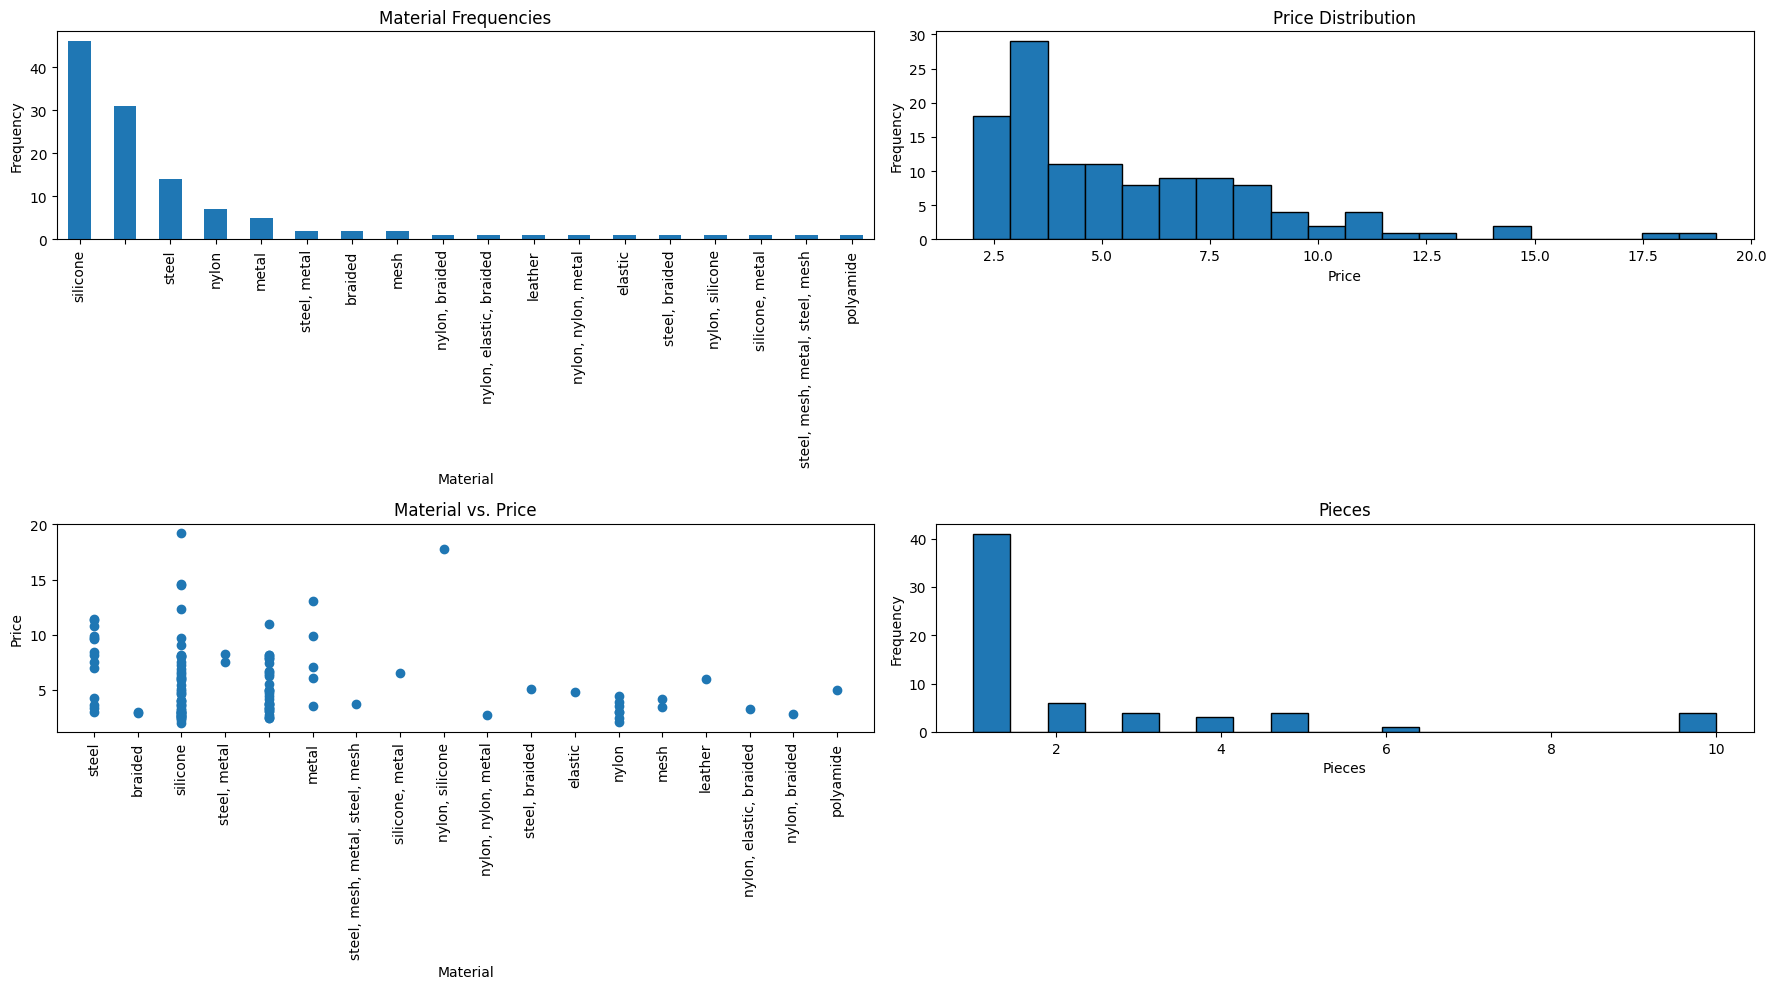

In [ ]:
plt.figure(figsize=(18, 10))

# Material Frequencies
plt.subplot(2, 2, 1)
material_counts = df['material'].value_counts()
material_counts.plot(kind='bar')
plt.title('Material Frequencies')
plt.xlabel('Material')
plt.ylabel('Frequency')

# Price Distribution
plt.subplot(2, 2, 2)
plt.hist(df['price'], bins=20, edgecolor='k')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Scatter plot of Material vs. Price
plt.subplot(2, 2, 3)
plt.scatter(df['material'], df['price'])
plt.xlabel('Material')
plt.ylabel('Price')
plt.title('Material vs. Price')
plt.xticks(rotation=90)

# Pieces
plt.subplot(2, 2, 4)
df['pieces'].plot(kind='hist', bins=20, edgecolor='k')
plt.title('Pieces')
plt.xlabel('Pieces')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

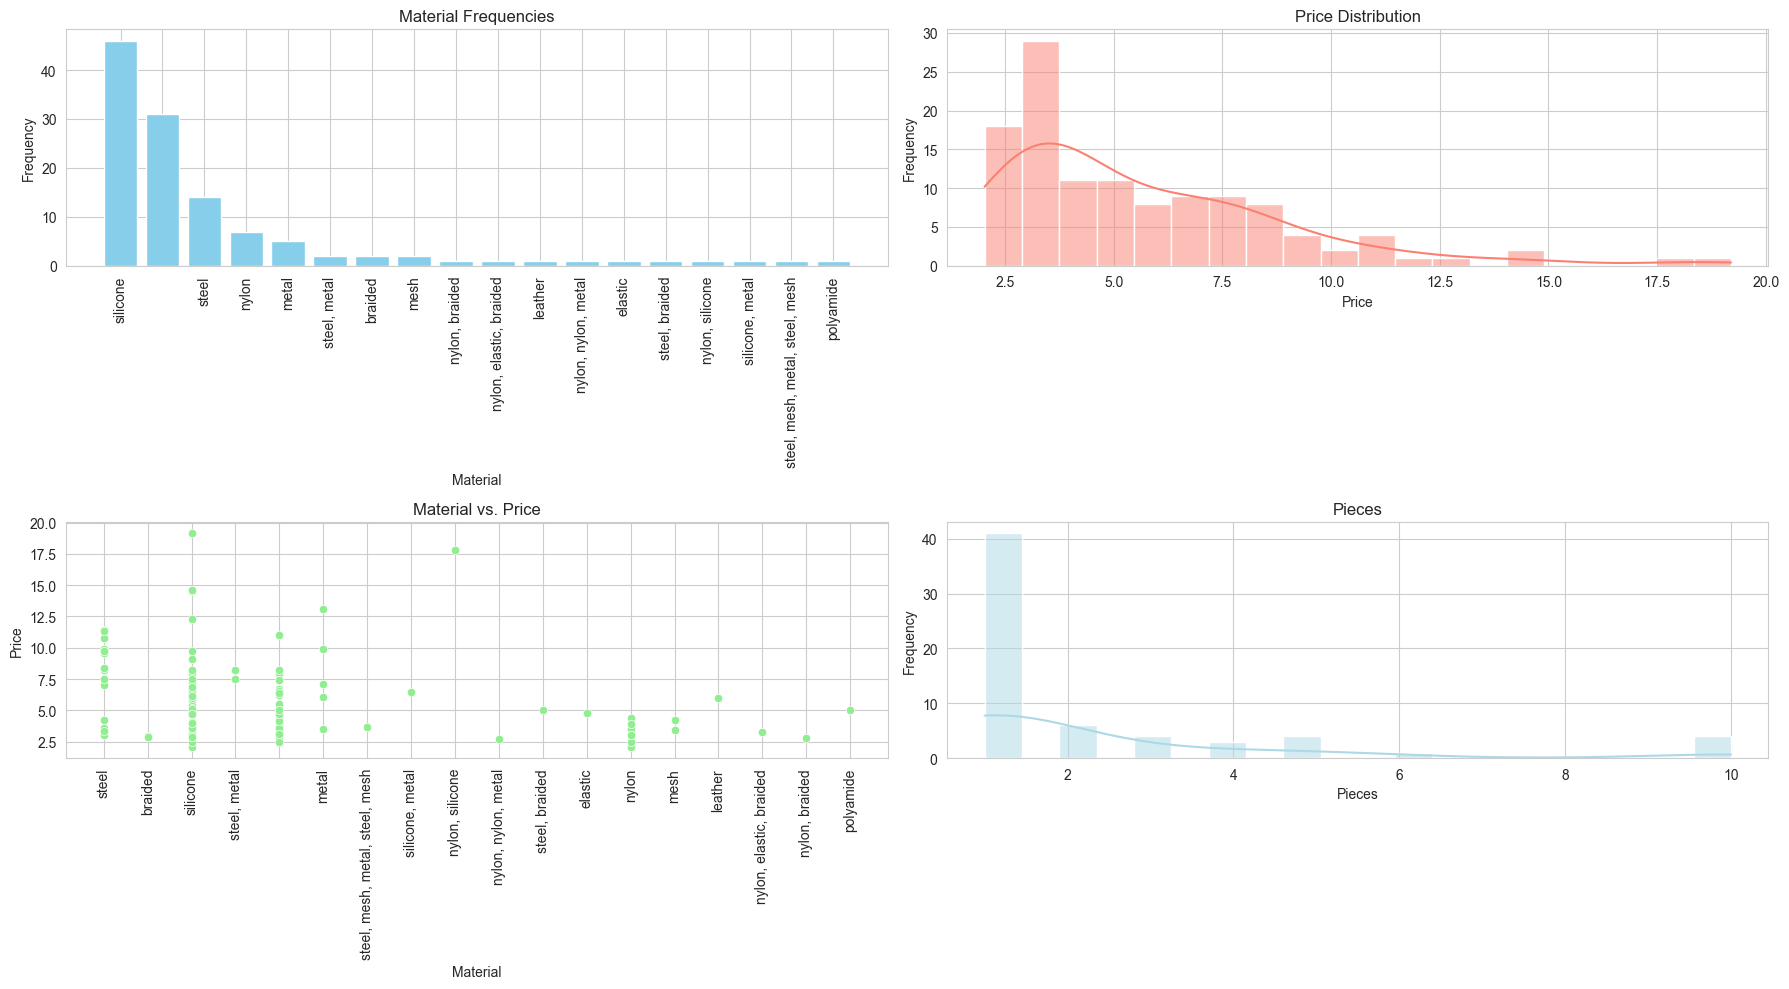

In [ ]:
# Set a custom style (optional)
sns.set_style("whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Material Frequencies
axs[0, 0].bar(material_counts.index, material_counts.values, color='skyblue')
axs[0, 0].set_title('Material Frequencies')
axs[0, 0].set_xlabel('Material')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].tick_params(axis='x', rotation=90)

# Price Distribution
sns.histplot(df['price'], bins=20, kde=True, color='salmon', ax=axs[0, 1])
axs[0, 1].set_title('Price Distribution')
axs[0, 1].set_xlabel('Price')
axs[0, 1].set_ylabel('Frequency')

# Scatter plot of Material vs. Price
sns.scatterplot(x='material', y='price', data=df, ax=axs[1, 0], color='lightgreen')
axs[1, 0].set_title('Material vs. Price')
axs[1, 0].set_xlabel('Material')
axs[1, 0].set_ylabel('Price')
axs[1, 0].tick_params(axis='x', rotation=90)

# Pieces
sns.histplot(df['pieces'], bins=20, kde=True, color='lightblue', ax=axs[1, 1])
axs[1, 1].set_title('Pieces')
axs[1, 1].set_xlabel('Pieces')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
conn = sqlite3.connect('shein_data.db')
cursor = conn.cursor()

cursor.execute('SELECT product_name, price, pieces, material FROM products ORDER BY price DESC LIMIT 10')
expensive_products = cursor.fetchall()

cursor.execute('SELECT product_name, price, pieces, material FROM products ORDER BY price ASC LIMIT 10')
cheap_products = cursor.fetchall()

conn.close()


expensive_names, expensive_price, expensive_pieces, expensive_material = zip(*expensive_products)
cheap_names, cheap_price, cheap_pieces, cheap_material = zip(*cheap_products)

expensive_pieces = (np.array(expensive_pieces)).astype(float)
expensive_price = (np.array(expensive_price)).astype(float)
cheap_pieces = (np.array(cheap_pieces)).astype(float)
cheap_price = (np.array(cheap_price)).astype(float)

more_expensive = []
more_cheap = []

for name, price, pieces, material in expensive_products:
    more_expensive.append({'Product Name': name, 'Price': price, 'Pieces': pieces, 'Material': material})

for name, price, pieces, material in cheap_products:
    more_cheap.append({'Product Name': name, 'Price': price, 'Pieces': pieces, 'Material': material})

save_to_csv(more_expensive, 'more_expensive.csv')
save_to_csv(more_cheap, 'more_cheap.csv')

def limit_name_length(name):
    return name[:25]

expensive_names = [limit_name_length(name) for name in expensive_names]
cheap_names = [limit_name_length(name) for name in cheap_names]


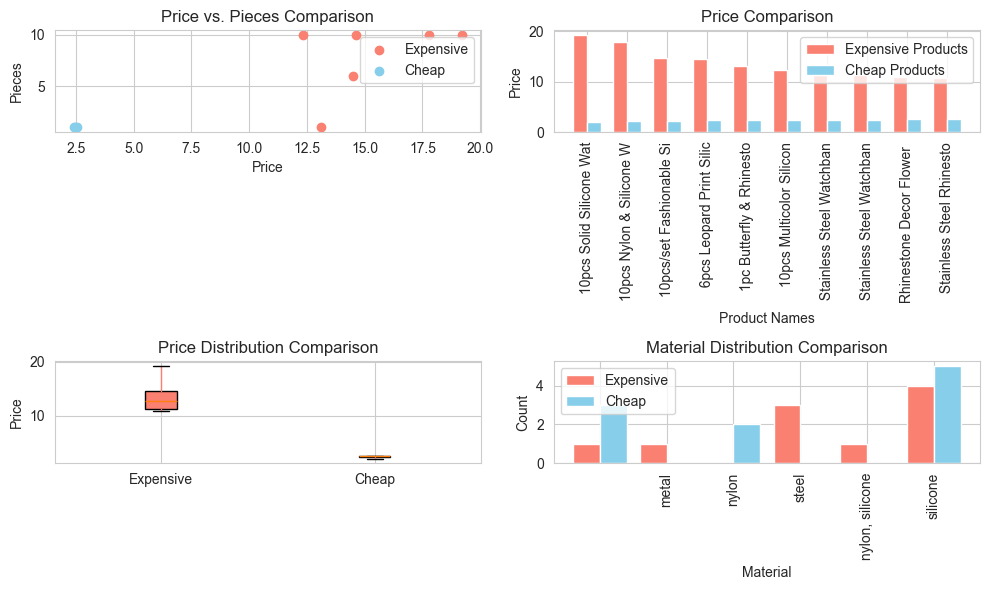

In [ ]:
# Set Seaborn style
sns.set_style("whitegrid")

# Define custom color palette
palette = sns.color_palette(['skyblue', 'salmon', 'lightgreen', 'lightblue'])

# Your data and calculations here

# Visualization 1: Scatter plot
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)

plt.scatter(expensive_price, expensive_pieces, color=palette[1], label='Expensive')
plt.scatter(cheap_price, cheap_pieces, color=palette[0], label='Cheap')

plt.xlabel('Price')
plt.ylabel('Pieces')
plt.title('Price vs. Pieces Comparison')
plt.legend()

# Visualization 2: Bar chart
plt.subplot(2, 2, 2)

bar_width = 0.35
index = np.arange(len(expensive_names))

plt.bar(index, expensive_price, bar_width, color=palette[1], label='Expensive Products')
plt.bar(index + bar_width, cheap_price, bar_width, color=palette[0], label='Cheap Products')

plt.xlabel('Product Names')
plt.ylabel('Price')
plt.title('Price Comparison')
plt.xticks(index + bar_width / 2, expensive_names, rotation='vertical')
plt.legend()

# Visualization 3: Box plot
plt.subplot(2, 2, 3)

boxprops = dict(facecolor=palette[1])
whiskerprops = dict(color=palette[1])
plt.boxplot([expensive_price, cheap_price], labels=['Expensive', 'Cheap'], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops)

plt.ylabel('Price')
plt.title('Price Distribution Comparison')

# Visualization 4: Bar chart for material distribution
plt.subplot(2, 2, 4)

materials = list(set(expensive_material + cheap_material))
expensive_material_counts = Counter(expensive_material)
cheap_material_counts = Counter(cheap_material)

expensive_counts = [expensive_material_counts[mat] for mat in materials]
cheap_counts = [cheap_material_counts[mat] for mat in materials]

x = range(len(materials))

plt.bar(x, expensive_counts, width=0.4, color=palette[1], label='Expensive')
plt.bar([i+0.4 for i in x], cheap_counts, width=0.4, color=palette[0], label='Cheap')

plt.xlabel('Material')
plt.ylabel('Count')
plt.title('Material Distribution Comparison')
plt.xticks([i+0.2 for i in x], materials, rotation='vertical')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
one_piece_products = [product for product in some_pages if product['Pieces'] == 1]

material_prices = {}
for product in one_piece_products:
    for material in product['Material']:
        if material not in material_prices:
            material_prices[material] = []
        material_prices[material].append(product['Price'])

price_per_piece = {material: round(sum(prices) / len(prices), 2) for material, prices in material_prices.items()}


sorted_materials = sorted(price_per_piece.items(), key=lambda x: x[1], reverse=True)

In [ ]:
print(sorted_materials)

[('metal', 7.29), ('steel', 6.38), ('silicone', 4.23), ('mesh', 3.76), ('nylon', 3.6), ('elastic', 3.3), ('braided', 3.13)]


In [ ]:
cheapest_products = sorted(one_piece_products, key=lambda x: x['Price'])

good_material = sorted_materials[0][0]

cheapest_good_material = [product for product in cheapest_products if good_material in product['Material']][:5]


In [ ]:
for product in cheapest_good_material:
    print(f"Material: {good_material}, Price: {product['Price']}, Product Name: {product['Product Name']}")

Material: metal, Price: 3.51, Product Name:  1pc Apple Watch Band Fashion Silver Milanese Loop Apple Strap Compatible With Apple Watch Magnetic Metal Strap Compatible With Apple Watch Band se 40mm 41mm 38mm 42mm 44mm 45mm 49mm Wristband Compatible With Apple Watch Series Ultra SE 8/7/6/5/4/3
Material: metal, Price: 3.7, Product Name:  1pc Milanese Soft Steel Mesh Magnetic Buckle Watch Strap  With Apple Watch Band 38mm 40mm 41mm 42mm 44mm 45mm 49mm  Strap Metal Magnetic Bands Stainless Steel Milanese Mesh Loop Sport Replacement Wristband Ultra Apple Watch Series 8 7 6 SE 5 4 3 2 1 For Women & Men - Rose Gold, Silver, Black, Gold, Blue
Material: metal, Price: 6.05, Product Name:  1pc Men Women Silver Color Fashionable Zinc Alloy Metal Apple Watch Band 38/40/41/42/44/45/49mm, Smart Watch Strap Accessories Compatible With Apple Watch Ultra/SE/8/7/6/5/4/3/2/1
Material: metal, Price: 6.5, Product Name:  1pc Black Ultra-thin Soft Waterproof Silicone Watch Band With Rose Gold Bee Shaped Metal 